In [1]:
import os, sys, imageio, math, scipy
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import raw_process5 as raw_process
from pylab import imshow, show
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
import importlib
importlib.reload(raw_process)

<module 'raw_process5' from '/home/moiz/work/raw_process/raw_process5.py'>

In [3]:
import rawpy
raw = rawpy.imread("chart.jpg")

In [4]:
h, w = raw.sizes.raw_height, raw.sizes.raw_width

In [5]:
print(raw.camera_whitebalance)

[1.128000020980835, 1.0, 2.5460000038146973, 1.0]


In [6]:
img = np.array(raw.raw_image).reshape((h, w)).astype('int')

In [7]:
blc_raw = raw_process.black_level_correction(img, raw.black_level_per_channel, raw.raw_pattern)

In [9]:
dpc_raw = blc_raw.copy()
single_channel = dpc_raw[::2, ::2]

footprint = np.ones((5, 5))
footprint[2, 2] = 0
local_max = scipy.ndimage.filters.maximum_filter(single_channel, footprint=footprint, mode='mirror')
local_min = scipy.ndimage.filters.minimum_filter(single_channel, footprint=footprint, mode='mirror')

threshold = 16
mask = (single_channel < local_min - threshold) + (single_channel > local_max + threshold)

flt = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
average = scipy.signal.convolve2d(single_channel, flt, mode='same')
single_channel[mask] = average[mask]

In [11]:
dpc_raw = blc_raw.copy()
footprint = np.ones((5, 5))
footprint[2, 2] = 0
for (yo, xo) in ((0, 0), (1, 0), (0, 1), (1, 1)):
    single_channel = dpc_raw[yo::2, xo::2]
    flt = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
    average = scipy.signal.convolve2d(single_channel, flt, mode='same')
    local_max = scipy.ndimage.filters.maximum_filter(single_channel, footprint=footprint, mode='mirror')
    local_min = scipy.ndimage.filters.minimum_filter(single_channel, footprint=footprint, mode='mirror')
    threshold = 16
    mask = (single_channel < local_min - threshold) + (single_channel > local_max + threshold)
    single_channel[mask] = average[mask]

In [12]:
lsc_coef = [np.array([6.07106808e-07, 9.60556906e-01]), 
           np.array([6.32044369e-07, 9.70694361e-01]), 
           np.array([6.28455183e-07, 9.72493898e-01]), 
           np.array([9.58743579e-07, 9.29427169e-01])]

In [13]:
lsc_raw = raw_process.lens_shading_correction(dpc_raw, lsc_coef)

In [14]:
wb_raw = raw_process.white_balance_Bayer(lsc_raw, raw.camera_whitebalance, raw.raw_pattern)

In [15]:
dms_img = raw_process.advanced_demosaic(wb_raw, raw.raw_pattern)

In [16]:
img_flt = raw_process.noise_filter(dms_img, coef=8, read_noise=2, shot_noise=246)

In [17]:
ccm_matrix = (6022,-2314,394,-936,4728,310,300,-4324,8126)
img_ccm = raw_process.color_correction_matrix(img_flt, ccm_matrix)

In [18]:
white_level = 1024
img_gamma = raw_process.gamma_correction(img_ccm / white_level, 2.2)

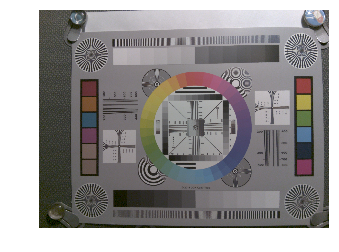

In [20]:
outimg = img_gamma.copy()
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.imshow(outimg)
plt.axis('off')
plt.show()

In [21]:
raw_process.write(img_gamma, "raspi_defect_correction.png")

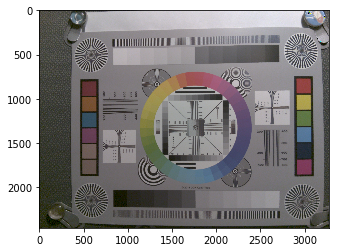

In [22]:
imshow(imageio.imread('raspi_defect_correction.png'))
show()

In [23]:
rgb2ycbcr = np.array([[0.299, 0.587, 0.144], [-0.168736, -0.331264, 0.5], [0.5, -0.418688, -0.081312]])

In [144]:
img_rgb = img_gamma.copy() * 256
img_rgb[img_rgb < 0] = 0
img_rgb[img_rgb > 255] = 255

In [126]:
img_ycbcr = np.zeros_like(img_rgb)
for c in (0, 1, 2):
    img_ycbcr[:, :, c] = rgb2ycbcr[c, 0] * img_rgb[:, :, 0] + \
                         rgb2ycbcr[c, 1] * img_rgb[:, :, 1] + \
                         rgb2ycbcr[c, 2] * img_rgb[:, :, 2]

In [127]:
luma = img_ycbcr[:, :, 0]

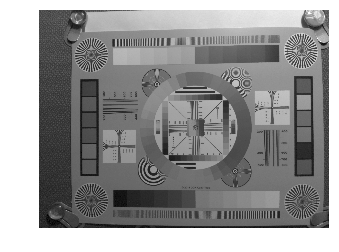

In [128]:
plt.imshow(luma, cmap='gray')
plt.axis('off')
plt.show()

In [129]:
raw_process.write(luma / 256, "no_sharpening.png")

In [130]:
unsharpen4 = scipy.ndimage.gaussian_filter(luma, sigma = 2)
unsharpen2 = scipy.ndimage.gaussian_filter(luma, sigma = 1)

In [131]:
sharpen = luma + 0.25 * (luma - unsharpen4) + 0.25 * (luma - unsharpen2)

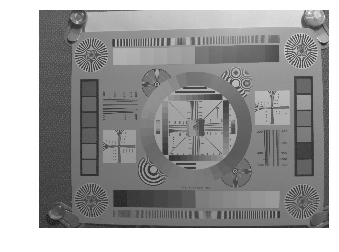

In [132]:
plt.imshow(sharpen, cmap='gray')
plt.axis('off')
plt.show()

In [133]:
raw_process.write(sharpen / 256, "unsharp_mask.png")

In [134]:
ycbcr2rgb = np.linalg.inv(rgb2ycbcr)

In [137]:
img_shp = img_ycbcr.copy()
img_shp[:, :, 0] = sharpen
img_shp_rgb = np.zeros_like(img_shp)
for c in (0, 1, 2):
    img_shp_rgb[:, :, c] = ycbcr2rgb[c, 0] * img_shp[:, :, 0] + \
                           ycbcr2rgb[c, 1] * img_shp[:, :, 1] + \
                           ycbcr2rgb[c, 2] * img_shp[:, :, 2]
img_shp_rgb[img_shp_rgb<0] = 0
img_shp_rgb[img_shp_rgb>255] = 255

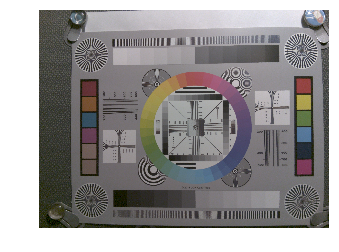

In [139]:
plt.imshow(img_shp_rgb / 256)
plt.axis('off')
plt.show()

In [36]:
raw_process.write(img_out / 256, "sharpened.png")

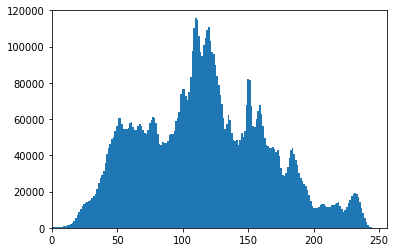

In [118]:
plt.hist(sharpen.flatten(), 256)
plt.axis((0, 256, 0, 120000))
plt.show()

In [108]:
xs = [0, 72, 128, 200, 256]
ys = [0, 56, 128, 220, 256]

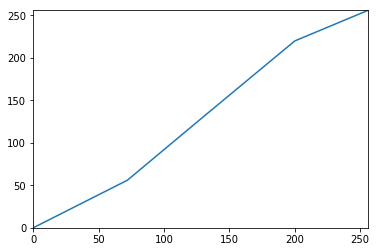

In [120]:
plt.plot(xs, ys)
plt.axis((0, 256, 0, 256))
plt.show()

In [109]:
func = scipy.interpolate.splrep(xs, ys)

In [110]:
xx = np.arange(0, 255)

In [111]:
yy = scipy.interpolate.splev(xx, func)

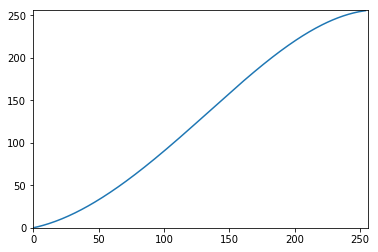

In [119]:
plt.plot(xx, yy)
plt.axis((0, 256, 0, 256))
plt.show()

In [113]:
adjusted = scipy.interpolate.splev(sharpen, func)

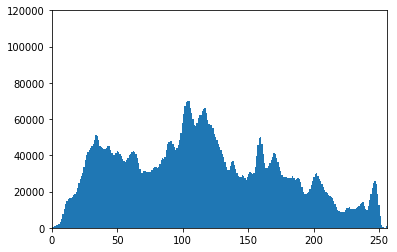

In [114]:
plt.hist(adjusted.flatten(), 256)
plt.axis((0, 256, 0, 120000))
plt.show()

In [115]:
img_shp = img_ycbcr.copy()
img_shp[:, :, 0] = adjusted
img_out = np.zeros_like(img_shp)
for c in (0, 1, 2):
    img_out[:, :, c] = ycbcr2rgb[c, 0] * img_shp[:, :, 0] + \
                           ycbcr2rgb[c, 1] * img_shp[:, :, 1] + \
                           ycbcr2rgb[c, 2] * img_shp[:, :, 2]
img_out[img_out<0] = 0
img_out[img_out>255] = 255

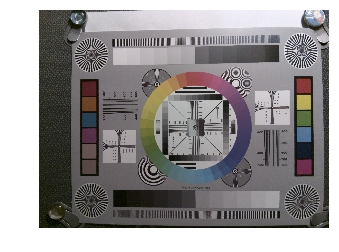

In [116]:
plt.imshow(img_out / 256)
plt.axis('off')
plt.show()

In [117]:
raw_process.write(img_out / 256, "tone_adjusted.png")

In [142]:
tone_adjusted = scipy.interpolate.splev(img_shp_rgb, func)
tone_adjusted[tone_adjusted<0] = 0
tone_adjusted[tone_adjusted>255] = 255

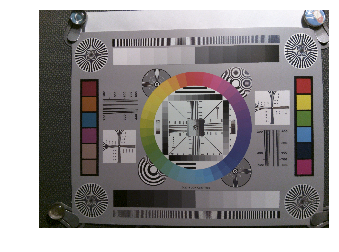

In [143]:
plt.imshow(tone_adjusted / 256)
plt.axis('off')
plt.show()